<a href="https://colab.research.google.com/github/moo0la/final_peoject/blob/main/ML_Bitcoin_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bitcoin price predictor use ML

## Import the necessary libraries

In [2]:
!pip install arch

     |████████████████████████████████| 902 kB 7.5 MB/s 
     |████████████████████████████████| 9.8 MB 38.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings("ignore")
import arch


##Fetching data from the server , organize it and clean it

In [4]:
url = 'https://api.binance.com/api/v3/klines'
r = requests.get(url,params={'symbol':'BTCUSDT','interval': '1d','limit':2000})
r

<Response [200]>

### Frame Collumn Formatting

In [5]:
collumns = """

1499040000000,      // Open time
    "0.01634790",       // Open
    "0.80000000",       // High
    "0.01575800",       // Low
    "0.01577100",       // Close
    "148976.11427815",  // Volume
    1499644799999,      // Close time
    "2434.19055334",    // Quote asset volume
    308,                // Number of trades
    "1756.87402397",    // Taker buy base asset volume
    "28.46694368",      // Taker buy quote asset volume
    "17928899.62484339" // Ignore.

""".split("//")[1:-1]


my_col_names = [sub_str.split('\n')[0].lower().strip().replace(' ','_') for sub_str in collumns]
# my_col_names.insert(0, 'timestamp')
my_col_names.append('ignore')
my_col_names

['open_time',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'close_time',
 'quote_asset_volume',
 'number_of_trades',
 'taker_buy_base_asset_volume',
 'taker_buy_quote_asset_volume',
 'ignore']

In [6]:
df = pd.DataFrame(r.json(),columns = my_col_names)
df.index = pd.to_datetime(df.open_time*1000000)
#df.index = pd.DatetimeIndex(df.open_time*1000000)
df.index.name = 'Date'
df = df.drop(columns=['open_time','close_time','ignore'])
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
Date,,,,,,,,,
2019-04-13,5047.00000000,5099.00000000,5004.00000000,5045.22000000,17292.45680200,87375984.44461506,138674,8692.05325900,43925293.92220215
2019-04-14,5047.45000000,5152.99000000,5000.00000000,5131.30000000,18281.60773900,92594930.42710131,131700,10043.91166700,50893945.02767781
2019-04-15,5131.28000000,5167.38000000,4950.00000000,5024.95000000,29057.19158100,147687551.94147710,204944,14170.25240200,72070166.00084409
2019-04-16,5024.95000000,5197.72000000,5003.94000000,5173.72000000,24242.22949300,123581651.71216356,168550,12804.63376800,65290617.51599363
2019-04-17,5173.72000000,5230.40000000,5146.80000000,5202.82000000,23307.53613400,120972345.51821637,179490,12172.53172400,63190167.89632924
...,...,...,...,...,...,...,...,...,...
2022-01-02,47722.66000000,47990.00000000,46654.00000000,47286.18000000,18340.46040000,866610995.56335820,709624,9166.46954000,433182392.28194660
2022-01-03,47286.18000000,47570.00000000,45696.00000000,46446.10000000,27662.07710000,1292203508.32565490,885624,13524.76045000,631879430.11428000
2022-01-04,46446.10000000,47557.54000000,45500.00000000,45832.01000000,35491.41360000,1649170424.12761340,1021815,17689.26808000,821725463.08080750


In [7]:
r = requests.get(url,params={'symbol':'BTCUSDT','interval': '1d','limit':2000,'endTime':(1641348720-1)*2000})
pd.DatetimeIndex(pd.DataFrame(r.json(),columns = my_col_names).open_time*1000000)

DatetimeIndex(['2019-04-13', '2019-04-14', '2019-04-15', '2019-04-16',
               '2019-04-17', '2019-04-18', '2019-04-19', '2019-04-20',
               '2019-04-21', '2019-04-22',
               ...
               '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31',
               '2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06'],
              dtype='datetime64[ns]', name='open_time', length=1000, freq=None)

### Creating a new column for better representing day-wise values

In [8]:
df["low"] = pd.to_numeric(df["low"])
df["high"] = pd.to_numeric(df["high"])
df['Mean'] = (df['low'] + df['high'])/2
df=df.dropna()
df

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,Mean
Date,,,,,,,,,,
2019-04-13,5047.00000000,5099.00,5004.00,5045.22000000,17292.45680200,87375984.44461506,138674,8692.05325900,43925293.92220215,5051.500
2019-04-14,5047.45000000,5152.99,5000.00,5131.30000000,18281.60773900,92594930.42710131,131700,10043.91166700,50893945.02767781,5076.495
2019-04-15,5131.28000000,5167.38,4950.00,5024.95000000,29057.19158100,147687551.94147710,204944,14170.25240200,72070166.00084409,5058.690
2019-04-16,5024.95000000,5197.72,5003.94,5173.72000000,24242.22949300,123581651.71216356,168550,12804.63376800,65290617.51599363,5100.830
2019-04-17,5173.72000000,5230.40,5146.80,5202.82000000,23307.53613400,120972345.51821637,179490,12172.53172400,63190167.89632924,5188.600
...,...,...,...,...,...,...,...,...,...,...
2022-01-02,47722.66000000,47990.00,46654.00,47286.18000000,18340.46040000,866610995.56335820,709624,9166.46954000,433182392.28194660,47322.000
2022-01-03,47286.18000000,47570.00,45696.00,46446.10000000,27662.07710000,1292203508.32565490,885624,13524.76045000,631879430.11428000,46633.000
2022-01-04,46446.10000000,47557.54,45500.00,45832.01000000,35491.41360000,1649170424.12761340,1021815,17689.26808000,821725463.08080750,46528.770


In [9]:
dataset_for_prediction = df.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift()
dataset_for_prediction=dataset_for_prediction.dropna()
dataset_for_prediction

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,Mean,Actual
Date,,,,,,,,,,,
2019-04-14,5047.45000000,5152.99,5000.00,5131.30000000,18281.60773900,92594930.42710131,131700,10043.91166700,50893945.02767781,5076.495,5051.500
2019-04-15,5131.28000000,5167.38,4950.00,5024.95000000,29057.19158100,147687551.94147710,204944,14170.25240200,72070166.00084409,5058.690,5076.495
2019-04-16,5024.95000000,5197.72,5003.94,5173.72000000,24242.22949300,123581651.71216356,168550,12804.63376800,65290617.51599363,5100.830,5058.690
2019-04-17,5173.72000000,5230.40,5146.80,5202.82000000,23307.53613400,120972345.51821637,179490,12172.53172400,63190167.89632924,5188.600,5100.830
2019-04-18,5202.41000000,5287.00,5198.80,5258.44000000,22619.23900100,118573129.86520114,167110,12104.85293200,63464128.54331125,5242.900,5188.600
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-02,47722.66000000,47990.00,46654.00,47286.18000000,18340.46040000,866610995.56335820,709624,9166.46954000,433182392.28194660,47322.000,47081.500
2022-01-03,47286.18000000,47570.00,45696.00,46446.10000000,27662.07710000,1292203508.32565490,885624,13524.76045000,631879430.11428000,46633.000,47322.000
2022-01-04,46446.10000000,47557.54,45500.00,45832.01000000,35491.41360000,1649170424.12761340,1021815,17689.26808000,821725463.08080750,46528.770,46633.000


##LinearRegression MODEL

In [10]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
N=2411

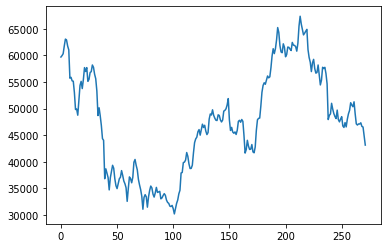

In [11]:
X=[]
for i in range(2411):
    X.append([i])
X=np.array(X)
Xtrain=X[:N]
Xtest=X[-272:]
Y=df["Mean"]
Y=np.array(Y,dtype='float32')
ytrain=Y[:N]
ytest=Y[-272:]
arr=ytest
plt.plot(arr,label='actual')


## GARCH-SARIMAX model

In [12]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['low', 'high', 'open', 'close', 'volume', 'Mean']])
scaled_input = pd.DataFrame(scaled_input, index=dataset_for_prediction.index)
X= scaled_input
X.rename(columns={0:'low', 1:'high', 2:'open', 3:'close', 4:'volume', 5:'Mean'}, inplace=True)
print(X.head())

                 low      high      open     close    volume      Mean
Date                                                                  
2019-04-14  0.019505  0.000000  0.003945  0.005282  0.010082  0.003327
2019-04-15  0.018704  0.000225  0.005281  0.003586  0.037866  0.003042
2019-04-16  0.019568  0.000701  0.003586  0.005958  0.025451  0.003716
2019-04-17  0.021856  0.001212  0.005958  0.006422  0.023041  0.005120
2019-04-18  0.022688  0.002099  0.006415  0.007309  0.021267  0.005989


In [13]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output, index=dataset_for_prediction.index)
y=scaler_output
y.rename(columns={0:'BTC Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
print(y.head())

            BTC Price next day
Date                          
2019-04-14            0.002927
2019-04-15            0.003327
2019-04-16            0.003042
2019-04-17            0.003716
2019-04-18            0.005120


In [14]:
train_size=int(len(df) *0.9)
test_size = int(len(df)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [16]:
predic_garch =[]
for i in range(test_size):
  model= SARIMAX(pd.concat([train_y,test_y.iloc[:i+1]]),
  exog=pd.concat([train_X,test_X.iloc[:i+1]]),
  order=(0,1,1),
  seasonal_order =(0, 0, 1, 12),
  enforce_invertibility=False, enforce_stationarity=False)
  results= model.fit()
  garch = arch.arch_model(results.resid, p=1, q=1,vol='GARCH')
  garch_model = garch.fit(update_freq=1)
  garch_forecast = garch_model.forecast(start = train_size-1,horizon=1,method='simulation')
  predicted_et = garch_forecast.mean['h.1'].iloc[-1]
  predic_garch.append(predicted_et)
  print(predicted_et)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3511.356445360285
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3511.3564502560894
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0003137762513220855


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3516.8333795194885
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3516.833384404377
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002680627953208766


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3517.4786942688875
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3517.4786992118206
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002383305651609372


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3520.081511044845
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3520.081515960359
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002489979644540209


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3523.467075112993
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3523.4670803826143
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00023680365707405535


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3524.337719641324
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3524.337724788371
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00023775235388086521


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3525.0844832175426
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3525.0844882698316
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00022820283074524768


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3530.0525191668517
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3530.052524229899
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00021226167605201978


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3528.272390025323
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3528.2723951960784
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002333578779339522


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3530.7346989712537
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3530.7347042010256
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00022375189691432434


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3533.4724770195917
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3534.801123570258
Iteration:      3,   Func. Count:     36,   Neg. LLF: -679.3024125837497
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -679.3024047133645
            Iterations: 3
            Function evaluations: 36
            Gradient evaluations: 3
0.06152114176013472


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3535.4140573133045
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3535.4140626249773
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002344353929595045


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.

Iteration:      1,   Func. Count:      6,   Neg. LLF: -3538.910047697403
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3538.9100530108853
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00022176958941325456


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3538.4162616538783
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3538.416266835004
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00017552210794500664


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3545.9424220370574
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3545.9424272380584
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00018018618966910463


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.

Iteration:      1,   Func. Count:      6,   Neg. LLF: -3551.048486362346
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3551.0484915201396
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00022823182761210837


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3554.116224190896
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3554.11622944388
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00021866081275379105


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.

Iteration:      1,   Func. Count:      6,   Neg. LLF: -3555.3744819658014
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3555.374487578625
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00022462513109163483


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3556.693642991707
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3556.6936484816097
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00019504211271793628


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3561.935249215166
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3561.9352548459774
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.000214201375638887


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3565.6113762967184
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3567.1563737963756
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3567.15637951382
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
-1.4846858569149911e-05


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3570.336100235224
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3572.240288463613
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3572.240294144275
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
-9.173327995632243e-06


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3561.775729337064
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3563.6903403356055
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3563.690345504454
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
-5.829864016370552e-05


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3563.1374281470303
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3563.1374329369546
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00025153215387730283


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3566.3332274050495
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3566.333232440519
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002484877375198875


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3568.567896034065
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3568.567900900903
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002472972691180793


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3572.0256419104944
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3572.0256469009564
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00023983317643863264


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.

Iteration:      1,   Func. Count:      6,   Neg. LLF: -3572.0743247540076
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3572.0743295818947
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002532266969309891


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3574.482698643233
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3574.4827035805174
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002759117850753615


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3577.2352975184986
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3577.235302556822
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00027309862162803425


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3580.5427336459156
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3580.5427387258633
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00027143830630781135


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3583.7983174973615
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3583.798322511526
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.000267391452958338


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3587.250463964511
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3587.2504691147833
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00027202550910492083


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.

Iteration:      1,   Func. Count:      6,   Neg. LLF: -3593.7642458957935
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3593.7642513383526
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00033840386970873453


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3595.3266884011746
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3595.3266937430717
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002676747894050855


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3600.493956997634
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3600.4939624766757
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002480208766621422


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3598.841063418132
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3598.8410686364873
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00028243021860169167


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3601.568034822998
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3601.5680400258643
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002768787591308688


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3604.5421306266426
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3604.542135923292
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002648602535768438


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3608.232406015747
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3608.2324112667875
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002594313216304274


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3610.8348232802286
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3610.834828405448
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002605080851692602


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3607.845027233718
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3607.845032367656
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002993526958198993


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3611.0660581143125
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3611.066063092692
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00022832589507998637


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3617.110073645015
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3617.1100789937846
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00017939239163081258


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3619.8388325272063
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3619.8388375992627
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002733949438659034


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3623.607396805771
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3623.607402078513
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002211177227028918


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3628.0043884821034
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3628.0043937726314
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0003142787091383521


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3623.3700590166673
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3623.3700640871157
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0003114163648495351


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3628.326548537266
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3628.3265535033006
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002968570687926391


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3629.001881196964
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3629.001886107843
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0003005141450232982


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3626.981080405586
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3626.9810852672144
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00041981764111035264


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3630.590271642018
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3630.5902768122933
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002967251426261497


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3635.591825692799
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3635.59183092945
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002865243760827607


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3637.695476452746
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3637.6954816463394
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00029201633714359216


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3636.688360777918
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3641.0929223808193
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3641.092927470142
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
-1.2226014303636835e-05


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3640.6291504621945
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3640.6291554610716
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0003164107729199897


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3646.9168131318143
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3646.916818361483
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0003063908324364302


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3646.170486723753
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3646.1704918198393
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00023797428249190003


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3645.4065383221914
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3650.1122205453485
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3650.112225615486
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
4.9557690075664024e-06


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3647.4935955323845
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3647.493600476525
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00036475338653388253


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3647.7857239918617
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3652.2160837094852
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3652.2160887829737
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
-1.5296484411626951e-06


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3651.356912798332
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3651.356917829047
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00031861873324944223


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3655.502514545247
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3655.5025196119263
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0003316056961974376


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3657.896016802828
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3657.8960220043355
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0003817276008535385


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3659.556234722696
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3659.556239953905
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0003317098293996648


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3664.66163364936
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3664.6616387269987
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00031248285423741956


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3668.749184733636
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3668.749189871186
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00033650877941311327


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3670.880528302753
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3670.8805339097876
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0002799402616691776


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3666.537642462319
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3668.4847711184984
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3668.4847764453275
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
-0.0001808753612884502


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3674.57573531018
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3678.2012234310127
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3678.2012285917226
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
1.15543449425913e-05


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3678.749608666117
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3678.749613778209
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00030377475496159696


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3676.924909889547
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3681.1760593723884
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3681.1760647552783
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
1.1160375897836968e-05


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3680.9100082394357
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3680.910013288761
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00035141362299816653


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3678.2274304315747
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3680.305505833497
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3680.3055112711727
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
2.4547581104615633e-05


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3685.781985262278
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3687.971763281167
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3687.9717688111696
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
-0.0001511922932808374


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3687.8677004022347
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3692.1659064787423
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3692.165911688827
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
1.5482751435857045e-05


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3691.2701433737116
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3691.270148579363
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0004218108211329538


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3684.6967767795304
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3689.586373286756
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3689.5863785542047
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
7.020211618379284e-06


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3696.5609928797157
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3696.5609979880924
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00034347912640543066


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3699.425395580787
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3703.6834681597556
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3703.683473446266
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
1.1974340866209706e-05


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3703.04521710846
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3707.1820550648563
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3707.182060370946
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
1.3873679222089184e-05


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3698.2028305017075
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3702.449130307957
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3702.4491357926886
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
2.938490626793551e-06


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3704.6622822423337
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3706.837924695853
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3706.837930117372
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
-0.00017607362541626967


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3708.345087406149
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3709.9141312076517
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3709.9141363676863
            Iterations: 3
            Function evaluations: 20
            Gradient evaluations: 2
-0.0002468710283691775


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3711.106416035895
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3716.6984336355845
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3716.6984388019855
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
6.806837888881151e-07


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3710.2108744958177
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3711.733892940263
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3711.73389838123
            Iterations: 3
            Function evaluations: 20
            Gradient evaluations: 2
-0.0002443719717985046


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3721.613956243895
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3721.6139617150675
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00022362624357931055


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3726.0297132294745
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3726.0297189327066
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00032121218158613526


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3730.347051339988
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3730.3470566301685
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00032815675859154344


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3729.71764655259
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3734.259731714931
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3734.259736911853
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
1.1123412363571493e-05


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3721.472020328577
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3723.823856352448
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3723.8238616647936
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
-0.0001894235943775678


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3733.8439112495225
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3738.9884789063353
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3738.988484022518
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
1.886874401352826e-05


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3731.865447742665
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3736.2160075658185
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3736.2160129397407
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
5.737580084686086e-06


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3739.9901145142994
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3744.96738263453
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3744.9673877308355
            Iterations: 3
            Function evaluations: 21
            Gradient evaluations: 2
1.3620405114152722e-05


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3743.035154119948
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3743.035159042411
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.00038817797285210375


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3739.2683401361983
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3744.982610092974
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3744.9826153386743
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
9.346343162420709e-06


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3751.3499356673246
Iteration:      2,   Func. Count:     20,   Neg. LLF: -3753.180060299844
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3753.1800657888243
            Iterations: 2
            Function evaluations: 20
            Gradient evaluations: 2
-0.00018141639172623554


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3753.4881315059342
Iteration:      2,   Func. Count:     21,   Neg. LLF: -3758.750161883997
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3758.750167111524
            Iterations: 2
            Function evaluations: 21
            Gradient evaluations: 2
2.0122205823295278e-05


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3748.8924649953756
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3748.892469891127
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0004224630031853988


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: -3748.8924649953756
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -3748.892469891127
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
0.0004224630031853988


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


In [17]:
model= SARIMAX(train_y,
 exog=train_X,
 order=(0,1,1),
 seasonal_order =(0, 0, 1, 12),
 enforce_invertibility=False, enforce_stationarity=False)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


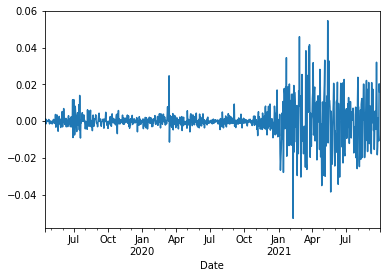

In [18]:
# training the model
results= model.fit()

# plotting residuals
results.resid.plot()

In [19]:
predictions= results.predict(start =train_size, end=train_size+test_size-2,exog=test_X)
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)
print(predictions)
for i in range(len(predictions)) : 
  predictions.iloc[i,0]= predictions.iloc[i,0]+predic_garch[i]


                Pred    Actual
Date                          
2021-09-30  0.587059  0.588809
2021-10-01  0.628415  0.606469
2021-10-02  0.687056  0.656277
2021-10-03  0.677039  0.688185
2021-10-04  0.691893  0.692579
...              ...       ...
2022-01-02  0.683458  0.675356
2022-01-03  0.676779  0.679203
2022-01-04  0.661379  0.668180
2022-01-05  0.653266  0.666513
2022-01-06  0.615131  0.638614

[99 rows x 2 columns]


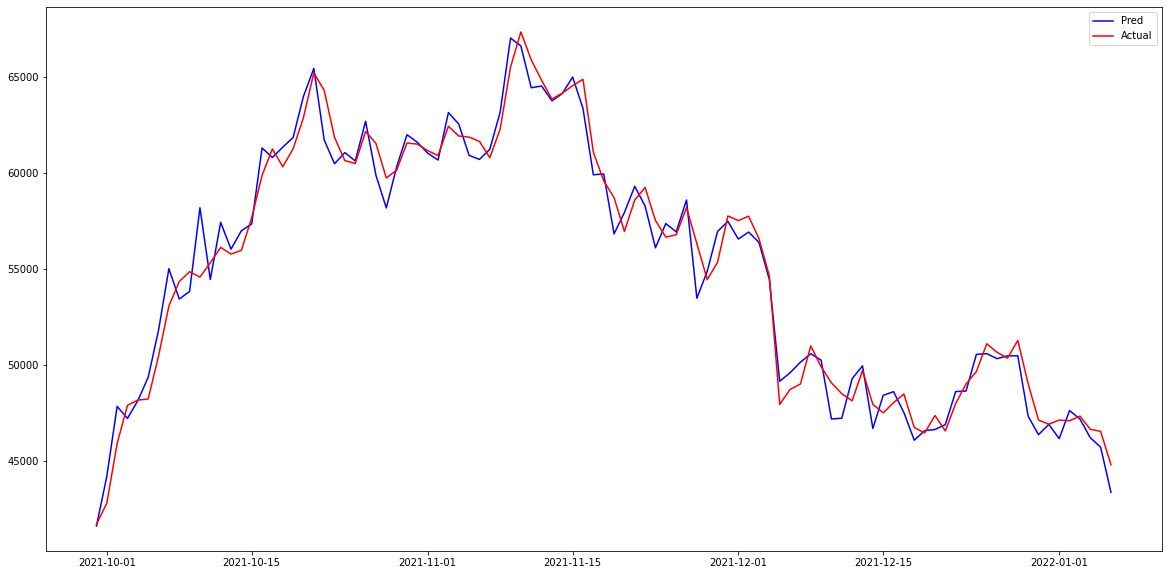

RMSE: [1056.42459276]


In [20]:
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['Actual']])

plt.figure(figsize=(20,10))
plt.plot(predictions.index, trainPredict, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.legend()
plt.show()

from statsmodels.tools.eval_measures import rmse
error=rmse(trainPredict, testPredict)
print("RMSE:",error)